### Getting pharmacophoric features for a couple of ligands

In [1]:
import molsysmt as msm
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import os
from pylab import *
from molecular_graph import molecular_graph
from prody import parsePDB, writePDBStream
from io import StringIO
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

#ignore warinings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load smiles data as a dictionary
with open('./smiles', 'rb') as f:
    smiles_dict = pickle.load(f)

In [3]:
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)

In [4]:
def get_ligand(pdb_id, res_name):
    """Get ligand from a pdb file and transform it into a rdkit molecule"""
    
    output = StringIO()
    
    # Get ligands from a pdb file
    pdb = parsePDB(pdb_id)
    ligand = pdb.select('not protein and not water')
    
    sub_mol = ligand.select("resname {}".format(res_name))
    
    # Get the smiles string and create a template molecule
    smiles = smiles_dict[res_name]
    template = Chem.MolFromSmiles(smiles)
    
    # Write a PDB strind for the ligand
    writePDBStream(output, sub_mol)
    pdb_string = output.getvalue()
    
    # Create the new molecule
    rd_mol = AllChem.MolFromPDBBlock(pdb_string)
    new_mol = AllChem.AssignBondOrdersFromTemplate(template, rd_mol)
    
    new_mol.RemoveAllConformers()
    
    return new_mol

### Examining pleconaril

In [5]:
# Load the molecular system from a pdb file
molecular_system = msm.convert('1NCR', 'molsysmt.MolSys')
molecular_system = msm.remove_solvent(molecular_system, water=True, ions=True)
molecular_system = msm.add_missing_hydrogens(molecular_system, pH=7.4)
msm.info(molecular_system, target='component')

index,n atoms,n groups,chain index,molecule index,molecule type,entity index,entity name
0,4489,285,0,0,protein,0,Protein_0
1,7571,490,1,1,protein,1,Protein_1
2,104,7,3,2,peptide,2,Peptide_0
3,332,22,3,3,peptide,3,Peptide_1
4,27,1,4,4,small molecule,4,W11
5,15,1,5,5,small molecule,5,MYR


@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ncr downloaded (1ncr.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 6717 atoms and 1 coordinate set(s) were parsed in 0.10s.


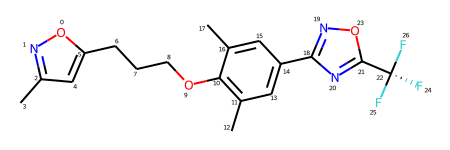

In [6]:
ligand = get_ligand('1ncr', 'W11')
ligand

Number of nodes: 27
Number of edges: 29


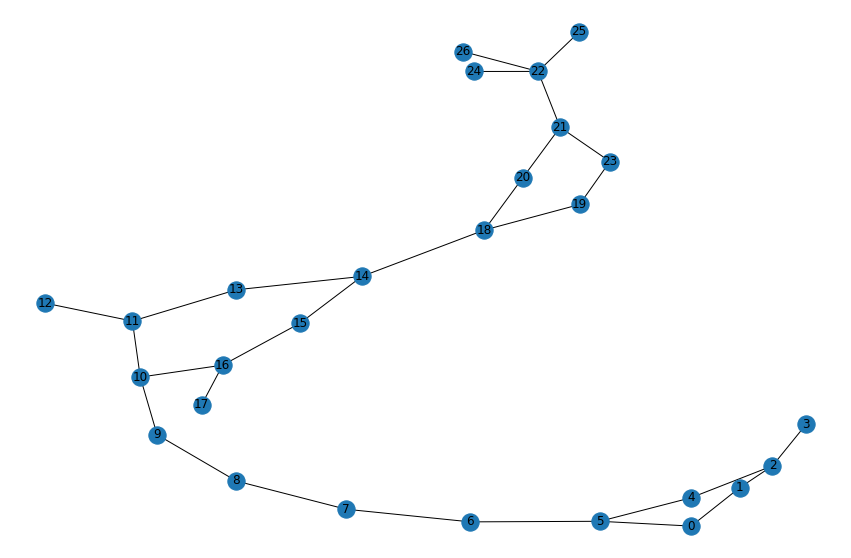

In [7]:
# Create the molecular graph for pleconaril
mol_graph = molecular_graph(molecular_system, selection='entity_name=="W11"', reset_index=True)

# Add the missing bonds
mol_graph.add_edge(22, 25)
mol_graph.add_edge(22, 26)
print("Number of nodes: {}".format(len(mol_graph.nodes())))
print("Number of edges: {}".format(len(mol_graph.edges())))

fig, ax = plt.subplots(figsize=(15,10))
nx.draw(mol_graph, with_labels=True, ax=ax)
show()

In [9]:
# Get features and assign them to the graph
feats = factory.GetFeaturesForMol(ligand)

for feature in feats:
    feat_name = feature.GetFamily()
    if feat_name == 'LumpedHydrophobe':
        continue
    for idx in feature.GetAtomIds():
        
        try:
            mol_graph.nodes[idx]['features']
        except KeyError:
            mol_graph.nodes[idx]['features'] = []
            
        mol_graph.nodes[idx]['features'].append(feat_name)

In [10]:
mol_graph.nodes[9]

{'atom_name': 'O1B',
 'atom_type': 'O',
 'coordinates': array([ 4.26800013,  0.1753    , 12.34449959]) <Unit('nanometer')>,
 'features': ['Acceptor']}

### Loading Pleconaril form an sdf file

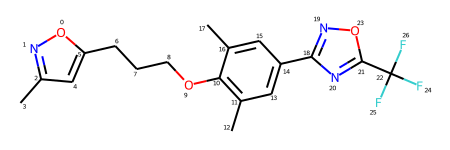

In [20]:
mol_ideal = Chem.SDMolSupplier('./data/ligands/W11_ideal.sdf')
mol_ideal = mol_ideal[0]
mol_ideal.RemoveAllConformers()
mol_ideal

,OPENEYE_ISO_SMILES,OPENEYE_INCHI,OPENEYE_INCHIKEY,FORMULA,ID,ROMol
0,Cc1cc(cc(c1OCCCc2cc(no2)C)C)c3nc(on3)C(F)(F)F,InChI=1S/C18H18F3N3O3/c1-10-7-13(16-22-17(27-2...,KQOXLKOJHVFTRN-UHFFFAOYSA-N,C18H18F3N3O3,W11,

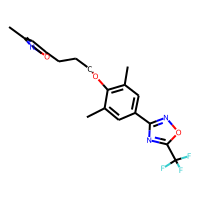

In [23]:
from rdkit.Chem import PandasTools
ligand_df = PandasTools.LoadSDF('./data/ligands/W11_model.sdf')
ligand_df

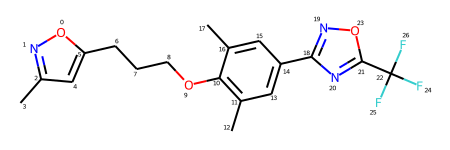

In [21]:
mol_model = Chem.SDMolSupplier('./data/ligands/W11_model.sdf')
mol_model = mol_model[0]
mol_model.RemoveAllConformers()
mol_model